## Two-way ANOVA

https://www.marsja.se/three-ways-to-carry-out-2-way-anova-with-python/

In [2]:
import pandas as pd
from statsmodels.formula.api import ols
import statsmodels as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
datafile = "ToothGrowth.csv"
data = pd.read_csv(datafile)

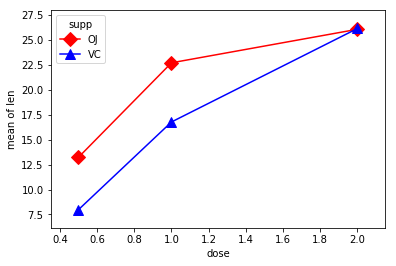

In [4]:
fig = interaction_plot(data.dose, 
                       data.supp, 
                       data.len,
                       colors=['red','blue'], markers=['D','^'], ms=10)

### Handmade ANOVA

In [5]:
N = len(data.len)
df_a = len(data.supp.unique()) - 1
df_b = len(data.dose.unique()) - 1
df_axb = df_a * df_b 
df_w = N - (len(data.supp.unique()) * len(data.dose.unique()))

In [6]:
grand_mean = data['len'].mean()

In [7]:
ssq_a = sum([(data[data.supp ==l].len.mean()-grand_mean)**2 for l in data.supp])

In [8]:
ssq_b = sum([(data[data.dose ==l].len.mean()-grand_mean)**2 for l in data.dose])

In [9]:
ssq_t = sum((data.len - grand_mean)**2)

In [10]:
vc = data[data.supp == 'VC']
oj = data[data.supp == 'OJ']
vc_dose_means = [vc[vc.dose == d].len.mean() for d in vc.dose]
oj_dose_means = [oj[oj.dose == d].len.mean() for d in oj.dose]
ssq_w = sum((oj.len - oj_dose_means)**2) +sum((vc.len - vc_dose_means)**2)

In [11]:
ssq_axb = ssq_t-ssq_a-ssq_b-ssq_w

In [12]:
ms_a = ssq_a/df_a

In [13]:
ms_b = ssq_b/df_b

In [14]:
ms_axb = ssq_axb/df_axb

In [15]:
ms_w = ssq_w/df_w

In [16]:
f_a = ms_a/ms_w
f_b = ms_b/ms_w
f_axb = ms_axb/ms_w

In [17]:
p_a = stats.f.sf(f_a, df_a, df_w)
p_b = stats.f.sf(f_b, df_b, df_w)
p_axb = stats.f.sf(f_axb, df_axb, df_w)

In [18]:
results = {'sum_sq':[ssq_a, ssq_b, ssq_axb, ssq_w],
           'df':[df_a, df_b, df_axb, df_w],
           'F':[f_a, f_b, f_axb, 'NaN'],
            'PR(>F)':[p_a, p_b, p_axb, 'NaN']}
columns=['sum_sq', 'df', 'F', 'PR(>F)']
 
aov_table1 = pd.DataFrame(results, columns=columns,
                          index=['supp', 'dose', 
                          'supp:dose', 'Residual'])

### Немного дополнительных показателей: 



In [19]:
def eta_squared(aov):
    aov['eta_sq'] = 'NaN'
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    return aov
 
def omega_squared(aov):
    mse = aov['sum_sq'][-1]/aov['df'][-1]
    aov['omega_sq'] = 'NaN'
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*mse))/(sum(aov['sum_sq'])+mse)
    return aov


eta_squared(aov_table1)
omega_squared(aov_table1)
aov_table1

,sum_sq,df,F,PR(>F),eta_sq,omega_sq
supp,205.350000,1,15.572,0.000231183,0.059484,0.055452
dose,2426.434333,2,92,4.04629e-18,0.702864,0.692579
supp:dose,108.319000,2,4.10699,0.0218603,0.031377,0.023647
Residual,712.106000,54,NaN,NaN,NaN,NaN


### ANOVA from `statsmodels`

In [72]:
formula = 'len ~ C(supp) + C(dose) + C(supp):C(dose)'
model = ols(formula, data).fit()
aov_table = anova_lm(model, typ=2)

In [73]:
eta_squared(aov_table)
omega_squared(aov_table)
aov_table

,sum_sq,df,F,PR(>F),eta_sq,omega_sq
C(supp),205.350000,1.0,15.571979,2.311828e-04,0.059484,0.055452
C(dose),2426.434333,2.0,91.999965,4.046291e-18,0.702864,0.692579
C(supp):C(dose),108.319000,2.0,4.106991,2.186027e-02,0.031377,0.023647
Residual,712.106000,54.0,NaN,NaN,NaN,NaN


### Q-Q график

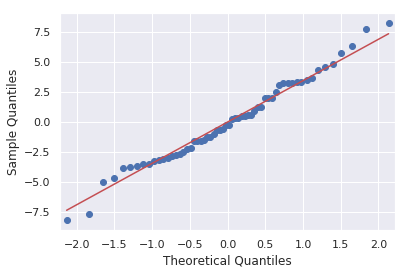

In [77]:
import statsmodels.api as sm

res = model.resid 
fig = sm.qqplot(res, line='s')
plt.show()

### Repeated Measures ANOVA

https://murraylax.org/rtutorials/ranova.pdf

https://www.marsja.se/repeated-measures-anova-in-python-using-statsmodels/

$$\mathbb{H}_0:~~\textrm{все средние равны для каждой "repeated-measured" категории}$$  $$~~\mathrm{vs}~~$$  $$\mathbb{H}_1: ~~ \textrm{не все средние равны}$$

In [6]:
import pandas as pd

In [15]:
df = pd.read_csv('./jobsat.csv')

In [13]:
df = df[['Colleague', 'Satisfaction', 'Promotion', 'Salary']]

In [22]:
df = df.reset_index()

In [23]:
from statsmodels.stats.anova import AnovaRM

In [25]:
flanks = pd.read_csv('flanks.csv')
res = AnovaRM(flanks, 'RT', 'SubID', within=['TrialType'], aggregate_func='mean')
 
print(res.fit())

                 Anova
          Num DF  Den DF F Value Pr > F
---------------------------------------
TrialType 1.0000 19.0000 24.7527 0.0001



In [26]:
df2way = pd.read_csv('rmAOV2way.csv')
aovrm2way = AnovaRM(df2way, 'rt', 'Sub_id', within=['iv1', 'iv2'])
res2way = aovrm2way.fit()
 
print(res2way)

                 Anova
        Num DF  Den DF   F Value  Pr > F
----------------------------------------
iv1     1.0000  59.0000 2207.0162 0.0000
iv2     2.0000 118.0000  275.4144 0.0000
iv1:iv2 2.0000 118.0000    1.8651 0.1594



/root/miniconda/lib/python3.6/site-packages/spm1d/stats/anova/ui.py:118: UserWarning: 

  if ((model.dim == 1) or _force_approx0D)   and   ( design.check_for_single_responses(dim=model.dim) ):
/root/miniconda/lib/python3.6/site-packages/spm1d/stats/anova/ui.py:118: UserWarning: 

  if ((model.dim == 1) or _force_approx0D)   and   ( design.check_for_single_responses(dim=model.dim) ):
/root/miniconda/lib/python3.6/site-packages/spm1d/stats/anova/ui.py:118: UserWarning: 

  if ((model.dim == 1) or _force_approx0D)   and   ( design.check_for_single_responses(dim=model.dim) ):


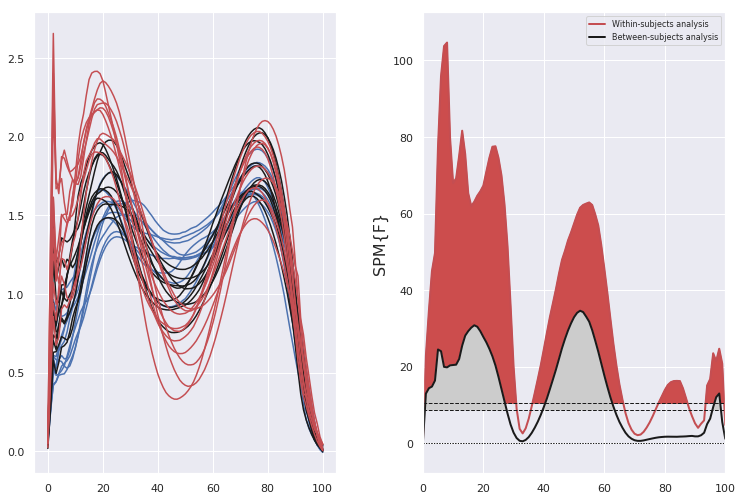

In [5]:
# http://www.spm1d.org/doc/Stats1D/anova.html#two-way-anova-with-repeated-measures-on-one-factor

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
import spm1d



#(0) Load data:
dataset      = spm1d.data.uv1d.anova1rm.SpeedGRFcategoricalRM()
Y,A,SUBJ     = dataset.get_data()




#(1) ANOVA:
alpha        = 0.05
equal_var    = True
F            = spm1d.stats.anova1(Y, A, equal_var)
Frm          = spm1d.stats.anova1rm(Y, A, SUBJ, equal_var)
Fi           = F.inference(alpha)
Firm         = Frm.inference(alpha)




#(2) Plot:
plt.close('all')
plt.figure( figsize=(12, 8) )
ax0     = plt.axes( (0.1, 0.15, 0.35, 0.8) )
ax1     = plt.axes((0.55,0.15,0.35,0.8))
### plot mean subject trajectories:
ax0.plot(Y[A==0].T, 'b')
ax0.plot(Y[A==1].T, 'k')
ax0.plot(Y[A==2].T, 'r')
### plot SPM results:
Firm.plot(ax=ax1, color='r', facecolor=(0.8,0.3,0.3), label='Within-subjects analysis')
Fi.plot(ax=ax1, label='Between-subjects analysis')
ax1.legend(fontsize=8)
# pyplot.show()



## Two-way ANOVA for repeated measures using Python

https://www.marsja.se/two-way-anova-repeated-measures-using-python/



In [86]:
import numpy as np
import pandas as pd
from collections import namedtuple

N = 20
P = [1,2]
Q = [1,2,3]
 
values = [[998,511], [1119,620], [1300,790]]
 
sub_id = [i+1 for i in range(N)]*(len(P)*len(Q))
mus = np.concatenate([np.repeat(value, N) for value in values]).tolist()
rt = np.random.normal(mus, scale=112.0, size=N*len(P)*len(Q)).tolist()
iv1 = np.concatenate([np.array([p]*N) for p in P]*len(Q)).tolist()
iv2 = np.concatenate([np.array([q]*(N*len(P))) for q in Q]).tolist()
 
 
Sub = namedtuple('Sub', ['Sub_id', 'rt','iv1', 'iv2'])               
df = pd.DataFrame()
 
for idx in range(len(sub_id)):
    df.insert(Sub(sub_id[idx],rt[idx], iv1[idx],iv2[idx])._asdict())    

TypeError: insert() missing 2 required positional arguments: 'column' and 'value'

In [87]:
df.box_plot('rt', factors=['iv1', 'iv2'])

OrderedDict([('Sub_id', 1),
             ('rt', 1173.1357306454893),
             ('iv1', 1),
             ('iv2', 1)])

In [88]:
aov = df.anova('rt', sub='Sub_id', wfactors=['iv1', 'iv2'])
print(aov)

AttributeError: 'DataFrame' object has no attribute 'anova'

### Random


http://www.spm1d.org/doc/RandomEffects.html#label-examples-statsadvanced



### Linear Mixed Models

https://github.com/statsmodels/statsmodels/wiki/Examples#linear-mixed-models

https://dpaniukov.github.io/2016/10/25/You-and-Your-R-Doing-Statistics-in-Python.html#linear-mixed-effects

http://www.statsmodels.org/stable/mixed_linear.html

In [89]:

import pandas as pd
import numpy as np
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
np.set_printoptions(threshold='nan') #to print the whole array

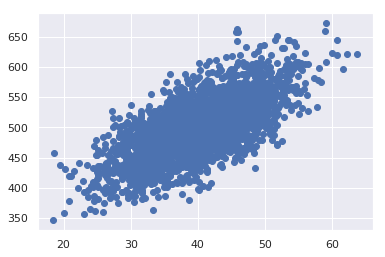

In [93]:
#generate correlated data
xx = np.array([-30.0, 110.0])
yy = np.array([0., 1000.0])
means = [xx.mean(), yy.mean()]  
stds = [xx.std() / 10, yy.std() / 10]
corr = 0.7         # correlation
covs = [[stds[0]**2          , stds[0]*stds[1]*corr],
        [stds[0]*stds[1]*corr,           stds[1]**2]]

m = np.random.multivariate_normal(means, covs, 2500).T
plt.scatter(m[0], m[1])


In [94]:
# categorical variable
cities = np.random.randint(0, 50, 2500,dtype='i')

# binary variable
kids =  np.random.randint(0, 2, 2500,dtype='i')


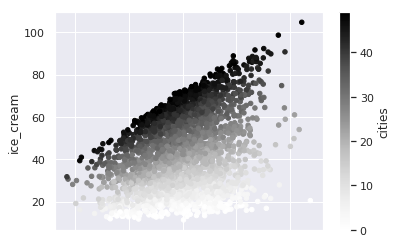

In [96]:
# Convert to Pandas. Here to make sense of all the models below, I made up some variable names.
df = pd.DataFrame({'ice_cream':m[1], 'temp': m[0], 'cities': cities, 'kids': kids})

# Assuming different cities have different preferences
for num in range(50):
    df['ice_cream'][df['cities']==num] += df['temp']*num

# Assuming liking ice cream is increased with kids (1; no kids = 0)
df['ice_cream'][df['kids']==1] += df['temp']*1.5

# scale
df['ice_cream'] = df['ice_cream']/35

# Here is how to plot the df
df.plot(x='temp', y='ice_cream', kind='scatter', c='cities')

In [97]:
mod1 = smf.glm('kids ~ ice_cream', data=df, family=sm.families.Binomial()).fit()

In [98]:
mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   kids   No. Observations:                 2500
Model:                            GLM   Df Residuals:                     2498
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1729.9
Date:                Fri, 15 Feb 2019   Deviance:                       3459.8
Time:                        17:27:40   Pearson chi2:                 2.50e+03
No. Iterations:                     4   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1433      0.106     -1.349      0.177      -0.352       0.065
ice_cream      0.0045      0.002      2.008      0.045       0.000       0.009
==============================================================================
"""

In [99]:
model1 = sm.MixedLM.from_formula("ice_cream ~ temp", data=df, groups=df["cities"]).fit(reml=False)

In [100]:
model1.summary()


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
========================================================
Model:            MixedLM Dependent Variable: ice_cream 
No. Observations: 2500    Method:             ML        
No. Groups:       50      Scale:              9.5490    
Min. group size:  37      Likelihood:         -6549.0818
Max. group size:  70      Converged:          Yes       
Mean group size:  50.0                                  
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      8.290    2.355  3.520 0.000  3.674 12.905
temp           0.873    0.009 95.236 0.000  0.855  0.891
Group Var    270.378   17.687                           
========================================================

"""

In [101]:
model2 = sm.MixedLM.from_formula("ice_cream ~ temp", data=df, re_formula="temp", groups=df["cities"]).fit(reml=False)

In [102]:
model2.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
==========================================================
Model:              MixedLM Dependent Variable: ice_cream 
No. Observations:   2500    Method:             ML        
No. Groups:         50      Scale:              1.8453    
Min. group size:    37      Likelihood:         -4537.1796
Max. group size:    70      Converged:          Yes       
Mean group size:    50.0                                  
----------------------------------------------------------
                 Coef. Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept        8.631    0.167 51.564 0.000  8.303  8.959
temp             0.864    0.058 14.852 0.000  0.750  0.978
Group Var        0.064    0.200                           
Group x temp Cov 0.029    0.051                           
temp Var         0.168    0.025                           
==========================================================

"""

Nested 

https://www.biostat.wisc.edu/~kbroman/teaching/labstat/fourth/notes11.pdf

http://www.biostathandbook.com/nestedanova.html

http://influentialpoints.com/Training/Nested_ANOVA_use_and_misuse.htm

https://www.researchgate.net/post/What_is_the_difference_between_a_nested_Anova_and_a_mixed_model_with_a_random_intercept

## Оффтопик: точный тест Фишера 

https://ru.wikipedia.org/wiki/%D0%A2%D0%BE%D1%87%D0%BD%D1%8B%D0%B9_%D1%82%D0%B5%D1%81%D1%82_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0